In [1]:
# !pip install torch==2.2
# !pip install torchvision
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !echo yevhenii | sudo -S apt-get install graphviz -y
# !pip install torchviz
# !pip install pandas

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
BATCH_SIZE = 64
num_epoch = 40
learning_rate = 0.0001
class_size = 10

INPUT_PATH = "/mnt/d/RESULTS/W4_X_s1/"
TRAIN_FILENAME_PREFIX = "QNN_TRAIN_CPU_cifar100_W4_X_"
TEST_FILENAME_PREFIX = "QNN_TEST_CPU_cifar100_W4_X_"

In [7]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.4),
                                      transforms.RandomRotation(30),
                                      # transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                    #  transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
train_start = 0
train_end = 50000

test_start = 0
test_end = 10000

def concat_parts(filename_prefix, end, step):
    q_train_images = np.load(INPUT_PATH + filename_prefix + "S0_E" + str(step) + "_s1.npy")
    for i in range(int(end / step) - 1):
        step_start = step * (i + 1)
        step_end = step_start + step
        q_train_images_part = np.load(INPUT_PATH + filename_prefix + "S" + str(step_start) + "_E" + str(step_end) + "_s1.npy")
        q_train_images = np.concatenate((q_train_images, q_train_images_part), axis=0)

    np.save(INPUT_PATH + filename_prefix + "S0_E" + str(end) + "_s1.npy", q_train_images)

In [9]:
# concat_parts(TRAIN_FILENAME_PREFIX, train_end, 1000)
# concat_parts(TEST_FILENAME_PREFIX, test_end, 5000)

q_train_images = np.load(INPUT_PATH + TRAIN_FILENAME_PREFIX + "S0_E" + str(train_end) + "_s1.npy")
q_test_images = np.load(INPUT_PATH + TEST_FILENAME_PREFIX + "S0_E" + str(test_end) + "_s1.npy")

In [10]:
torch.manual_seed(2024)

train = torchvision.datasets.CIFAR100("./data-cifar100/", train=True, download=True , transform=transforms.ToTensor())
test = torchvision.datasets.CIFAR100("./data-cifar100/", train=False, download=True , transform=transforms.ToTensor())

train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

train_labels = []
test_labels = []

for i, (_, labels) in enumerate(train_loader):
    for label in labels:
        train_labels.append(label)

for i, (_, labels) in enumerate(test_loader):
    for label in labels:
        test_labels.append(label)

# val_size = 10000
# train_size = len(train) - val_size

# train, val = random_split(train, [train_size, val_size])

# train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
# val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
q_train_images = torch.Tensor(q_train_images)
q_test_images = torch.Tensor(q_test_images)

print(f'shape of quantum train data: {q_train_images.shape}')
print(f'shape of quantum test data: {q_test_images.shape}')
print(f'shape of train labels: {len(train_labels)}')
print(f'shape of test labels: {len(test_labels)}')

reshaped_train_labels = torch.Tensor(train_labels * 4).to(torch.int64)
reshaped_test_labels = torch.Tensor(test_labels * 4).to(torch.int64)

print(f'shape of reshaped test labels: {reshaped_train_labels.shape}')
print(f'shape of test labels: {reshaped_test_labels.shape}')

shape of quantum train data: torch.Size([50000, 27, 27, 3, 4])
shape of quantum test data: torch.Size([10000, 27, 27, 3, 4])
shape of train labels: 50000
shape of test labels: 10000
shape of reshaped test labels: torch.Size([200000])
shape of test labels: torch.Size([40000])


In [12]:
train_output_shape = (4 * 50000, 27, 27, 3)
q_train_images = np.transpose(q_train_images, (4, 0, 1, 2, 3))
q_train_images = np.reshape(q_train_images, train_output_shape)
q_train_images = np.transpose(q_train_images, (0, 3, 1, 2))

test_output_shape = (4 * 10000, 27, 27, 3)
q_test_images = np.transpose(q_test_images, (4, 0, 1, 2, 3))
q_test_images = np.reshape(q_test_images, test_output_shape)
q_test_images = np.transpose(q_test_images, (0, 3, 1, 2))


In [13]:
print(f'shape of quantum train data: {q_train_images.shape}')
print(f'shape of quantum test data: {q_test_images.shape}')

shape of quantum train data: torch.Size([200000, 3, 27, 27])
shape of quantum test data: torch.Size([40000, 3, 27, 27])


In [14]:
# transformed_q_train_images = transform_train(q_train_images)
# transformed_q_test_images = transform_test(q_test_images)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

qcifar_train_dataset = TensorDataset(q_train_images, reshaped_train_labels)
q_train_loader = DataLoader(qcifar_train_dataset, batch_size=BATCH_SIZE)

qcifar_test_dataset = TensorDataset(q_test_images, reshaped_test_labels)
q_test_loader = DataLoader(qcifar_test_dataset, batch_size=BATCH_SIZE)

In [16]:
imgs, labels = next(iter(train_loader))

print(imgs.shape)
print(labels.shape)
print(labels.dtype)

q_imgs, q_labels = next(iter(q_train_loader))

print(q_imgs.shape)
print(q_labels.shape)
print(q_labels.dtype)

torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.int64
torch.Size([64, 3, 27, 27])
torch.Size([64])
torch.int64


shape:  torch.Size([64, 3, 32, 32])


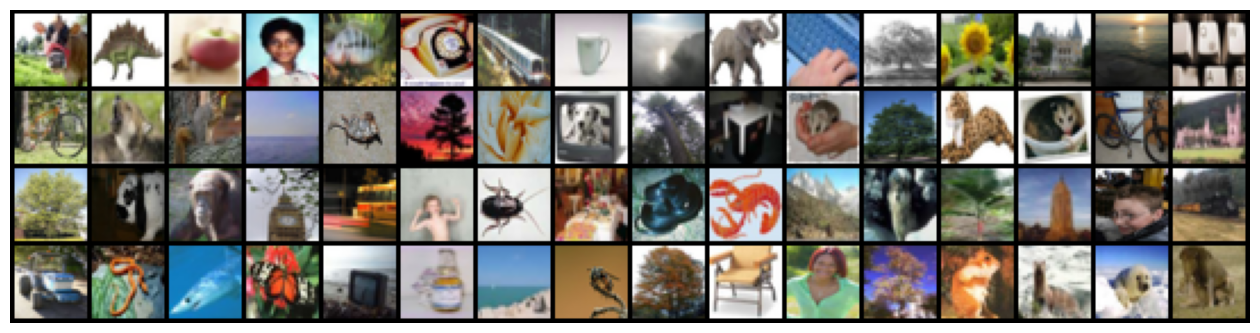

In [17]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape:  torch.Size([64, 3, 27, 27])


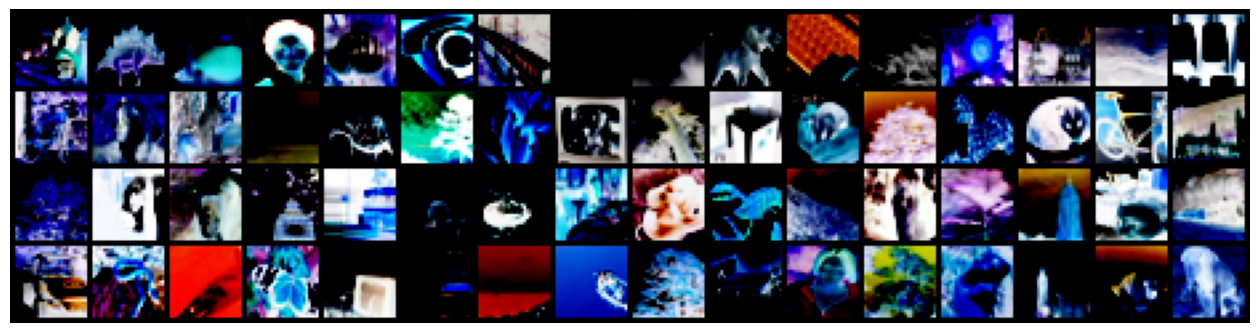

In [18]:
for images, _ in q_train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [19]:
from torchvision import models

model = models.efficientnet_v2_s(pretrained=True)

/home/yevhenii/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yevhenii/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/yevhenii/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████████████████████████████████████████████████████████████████████████| 82.7M/82.7M [00:02<00:00, 29.6MB/s]


In [20]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
# from torchsummary import summary

# summary(model.cuda(), (3, 224, 224))

In [20]:
# from torchview import draw_graph

# model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# model_graph.visual_graph

In [22]:
input_last_year = model.classifier[1].in_features
model.classifier[1] = nn.Linear(input_last_year, 100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [23]:
epoch_loss_history = []
epoch_acc_history = []

In [24]:
del train_loader
del test_loader
del train_labels
del test_labels
del train
del test

In [25]:

# preparation = transforms.Resize((224, 224))

for epoch in range(num_epoch):
    epoch_avg_loss = 0
    for i, (imgs, labels) in enumerate(q_train_loader):
        imgs = transforms.Resize((224, 224))(imgs.to(device))
        # imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_avg_loss += loss_value.item()
        
        accuracy = (n_corrects / labels.size(0)) * 100

        if (i+1) % 50 == 0:
            print(f'epoch {epoch + 1}/{num_epoch}, step: {i + 1}/{train_end*4/BATCH_SIZE}: loss = {loss_value:.5f}, acc = {accuracy:.2f}')
    
    epoch_loss_history.append(epoch_avg_loss / len(q_train_loader))

    with torch.no_grad():
        correct = 0
        samples = 0

        for i, (images, labels) in enumerate(q_test_loader):
            images = transforms.Resize((224, 224))(images.to(device))
            # images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = outputs.max(1)
            correct += (predictions == labels).sum()
            samples += predictions.size(0)
        
        accuracy = float(correct) / float(samples) * 100
        epoch_acc_history.append(accuracy)

        print(f"epoch {epoch + 1}/{num_epoch}, val accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")

/home/yevhenii/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1/40, step: 50/3125.0: loss = 4.45722, acc = 3.12
epoch 1/40, step: 100/3125.0: loss = 4.03225, acc = 10.94
epoch 1/40, step: 150/3125.0: loss = 3.02144, acc = 28.12
epoch 1/40, step: 200/3125.0: loss = 2.49814, acc = 37.50
epoch 1/40, step: 250/3125.0: loss = 2.21177, acc = 37.50
epoch 1/40, step: 300/3125.0: loss = 2.21736, acc = 48.44
epoch 1/40, step: 350/3125.0: loss = 1.66647, acc = 57.81
epoch 1/40, step: 400/3125.0: loss = 1.79015, acc = 51.56
epoch 1/40, step: 450/3125.0: loss = 1.52323, acc = 56.25
epoch 1/40, step: 500/3125.0: loss = 1.51169, acc = 57.81
epoch 1/40, step: 550/3125.0: loss = 1.28055, acc = 64.06
epoch 1/40, step: 600/3125.0: loss = 1.28399, acc = 68.75
epoch 1/40, step: 650/3125.0: loss = 1.24454, acc = 64.06
epoch 1/40, step: 700/3125.0: loss = 1.23235, acc = 65.62
epoch 1/40, step: 750/3125.0: loss = 1.08145, acc = 70.31
epoch 1/40, step: 800/3125.0: loss = 1.13411, acc = 68.75
epoch 1/40, step: 850/3125.0: loss = 1.02946, acc = 67.19
epoch 1/40, step

KeyboardInterrupt: 

In [26]:
print(epoch_loss_history)
with open('/mnt/c/phd/experiments/res/history/effnet_cifar_w4_x_s1_loss_history.txt', "w") as f:
    for item in epoch_loss_history:
        f.write(f'{item:.5f}\n')

[1.073087412467003, 0.24078964358091354, 0.11940542542815208, 0.08261378245830536, 0.06893947566654533, 0.05668464904798195, 0.050110688960412514]


In [27]:
print(epoch_acc_history)
with open('/mnt/c/phd/experiments/res/history/effnet_cifar_w4_x_s1_acc_history.txt', "w") as f:
    for item in epoch_acc_history:
        f.write(f'{item:.5f}\n')

[69.54249999999999, 70.35, 70.9975, 71.315, 71.545, 72.47, 72.255]


In [ ]:
# import pandas as pd

# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
# total_corrects =  0

# classes = set()

# for imgs, labels in test_loader:
#         for i in range(len(labels)):
#                 classes.add(labels[i])

# heatmap = pd.DataFrame(data=0, index=list(classes), columns=list(classes))

# with torch.no_grad():
#         for imgs, labels in test_loader:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)

#                 output = model(imgs)
#                 _, predicted = torch.max(output, 1)


#                 for i in range(labels.size(0)):
#                         if labels[i].item() == predicted[i].item():
#                                 total_corrects += 1
                        
#                         heatmap.iloc[labels[i].item(), predicted[i].item()] += 1

# _, ax = plt.subplots(figsize=(10, 8))
# ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
# plt.show()

In [28]:
torch.save(model, '/mnt/c/phd/experiments/res/effnet_cifar_w4_x_s1.pth')